In [1]:
import numpy as np
import tensorflow as tf

np.random.seed()
# tf.set_random_seed()

'''
CFO Multitap is a net that, given a known preamble, will take in the convolved preamble and estimate the CFO.
'''

class CFO_Multitap():
    def __init__(self, preamble_length = 50, batch_size = 150, learning_rate = 0.01):           
        
        # Network variables
        self.preamble_length = preamble_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Placeholders for training
        self.preamble_original = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.preamble_convolved = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.omega_original = tf.placeholder(tf.float32, [None, 1])
        self.preamble_channel = tf.placeholder(tf.float32, [None, self.preamble_length,2])
            
        ###############
        # CFO Estimation using preambles
        ###############
        preamble_original_cfo = tf.concat([self.preamble_original, self.preamble_convolved], 1)

        preamble_original_cfo_flat = tf.contrib.layers.flatten(preamble_original_cfo)

        cfo_layer_1 = tf.layers.dense(
          preamble_original_cfo_flat, 100, tf.nn.tanh, use_bias=True, name='cfo_layer_1')
        cfo_layer_2 = tf.layers.dense(
          cfo_layer_1, 100, tf.nn.tanh, use_bias=True, name='cfo_layer_2')
        cfo_layer_3 = tf.layers.dense(
          cfo_layer_2, 100, activation=tf.nn.tanh, use_bias=True, name='cfo_layer_3')
        cfo_layer_4 = tf.layers.dense(
          cfo_layer_3, 1, activation=tf.identity, use_bias=True, name='cfo_layer_4')

        self.est_omega = cfo_layer_4
        
        ###############
        # CFO Correction on the convolved data
        ###############

        preamble_cfo_complex = tf.complex(self.preamble_convolved[:,:,0], self.preamble_convolved[:,:,1])
        preamble_cfo_complex = tf.expand_dims(preamble_cfo_complex, -1)

        # build the rotation matrix
        incremented_omega = []
        for i in range(preamble_length):
            incremented_omega.append(-self.est_omega*i)

        rotation_complex = tf.exp(tf.complex(0.0,tf.transpose(incremented_omega, perm=[1,0,2])))
        preamble_rotated_complex = tf.multiply(preamble_cfo_complex,rotation_complex)

        preamble_rotated = tf.stack([tf.real(preamble_rotated_complex[:,:]), 
                                     tf.imag(preamble_rotated_complex[:,:])], axis=2)
        
        self.preamble_cfo_corrected = tf.squeeze(preamble_rotated,-1)
        
        self.mse_loss = tf.losses.mean_squared_error(self.preamble_channel, self.preamble_cfo_corrected)
    
    
        ###############################################
        # Define surrogate loss and optimization tensor
        ###############################################
        self.surr = tf.losses.mean_squared_error(self.omega_original, self.est_omega)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update_op = self.optimizer.minimize(self.surr)

        ###############
        # Start session
        ###############
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
            

    def test_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Test net function. Evaluates the session
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            test_cost, error between the data_original and the estimated data
        """

        test_cost, test_omega, test_mse_loss = self.sess.run([self.surr,self.est_omega, self.mse_loss], 
                                                             feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        return test_cost,test_omega, test_mse_loss
    
            
    def train_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Train net function. Calls self.update_op.
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            train_cost, error between the data_original and the estimated data
        """

        _ , train_cost = self.sess.run([self.update_op, self.surr], feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        return train_cost
    


/home/laura/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def data_generation(epochs):
    
    import numpy as np
    import scipy.signal as sig
    from numpy import linalg as LA
    import matplotlib.pyplot as plt

    # Create training and test data for the NN
    batch_size = 1500

    snr=10

    # number of random preambles that will be trained and tested on
    num_train=epochs*batch_size
    num_test=batch_size

    preamble_length = 40
    channel_length = 2

    # QPSK
    preamble_train_orig = np.zeros((num_train,preamble_length,2))
    preamble_train_cfo = np.zeros((num_train,preamble_length,2))
    preamble_test_channel = np.zeros((num_test,preamble_length,2))
    preamble_test_orig = np.zeros((num_test,preamble_length,2))
    preamble_test_cfo = np.zeros((num_test,preamble_length,2))
    preamble_train_noisy = np.zeros((num_train,preamble_length,2))
    preamble_test_noisy = np.zeros((num_test,preamble_length,2))

    # the max value the CFO rate can be 
    max_omega = 1/100
    # the cfo rate is in number of radians turned per sample
    omega_train = np.random.uniform(low=-max_omega,high=max_omega, size=((num_train,1)))
    omega_test = np.random.uniform(low=-max_omega,high=max_omega, size=((num_test,1)))
    
    # assume the channel length is the same for imaginary and real
    channel_train = np.zeros((num_train,channel_length,2))
    channel_test = np.zeros((num_test,channel_length,2))


    for i in range(num_train):
        # original preamble - known to both TX and RX
        preamble_train_orig[i,:,:] = ((2*np.random.randint(2,size=(preamble_length,2)))-1)*np.sqrt(2)/2
        
        
        preamble_train_channel = np.zeros((num_train,preamble_length,2))
        for k in range(2):
            channel_train[i,:,k]=np.random.uniform(0,1,channel_length)
#             channel_train[i,:,k]=([1,0])
            # normalize power to 1
            channel_train[i,:,k] = channel_train[i,:,k]/(np.linalg.norm(channel_train[i,:,k]))
            
            # apply the channel to the preamble
            preamble_train_channel[i,:,k] = sig.convolve(preamble_train_orig[i,:,k], 
                                                         channel_train[i,:,k], mode='same')
        
        
        # rotate data according to cfo
        preamble_cfo_complex = np.vectorize(complex)(preamble_train_channel[i,:,0], preamble_train_channel[i,:,1])
        preamble_cfo_complex = preamble_cfo_complex.reshape((preamble_length,1))
        # print(preamble_cfo_complex.shape)

        # build the rotation matrix
        incremented_omega = np.zeros((preamble_length,1))
        for j in range(preamble_length):
            incremented_omega[j]=omega_train[i]*j

        rotation_complex = np.exp(0.0+1j*incremented_omega)
        preamble_rotated_complex = (preamble_cfo_complex*rotation_complex)

        preamble_train_cfo[i,:,:] = np.squeeze(np.stack([np.real(preamble_rotated_complex[:,:]), 
                                     np.imag(preamble_rotated_complex[:,:])], axis=1),axis=-1)
        
#         # rotate data according to cfo
#         for j in range(preamble_length):
#             preamble_train_cfo[i,j,0]=(preamble_train_channel[i,j,0]*np.cos(omega_train[i]*j)
#                                            -preamble_train_channel[i,j,1]*np.sin(omega_train[i]*j))
#             preamble_train_cfo[i,j,1]=(preamble_train_channel[i,j,0]*np.sin(omega_train[i]*j)
#                                           +preamble_train_channel[i,j,1]*np.cos(omega_train[i]*j))
            
        # add AWG noise to the preamble
        if snr > 0:
            preamble_train_noisy[i,:,:] = (1./np.sqrt(snr)) * np.random.randn(preamble_length,2)+preamble_train_cfo[i,:,:]
            
        if i % 100000 == 0:
            print(i)


    for i in range(0, num_test):
        # original preamble - known to both TX and RX
        preamble_test_orig[i,:,:] = ((2*np.random.randint(2,size=(preamble_length,2)))-1)*np.sqrt(2)/2
       
        
        for k in range(2):
            channel_test[i,:,k]=np.random.uniform(0,1,channel_length)
#             channel_test[i,:,k]=([1,0])
            # normalize power to 1
            channel_test[i,:,k] = channel_test[i,:,k]/(np.linalg.norm(channel_test[i,:,k]))
            
            # apply the channel to the preamble
            preamble_test_channel[i,:,k] = sig.convolve(preamble_test_orig[i,:,k], 
                                                        channel_test[i,:,k], mode='same')
        
        # rotate data according to cfo
        preamble_cfo_complex = np.vectorize(complex)(preamble_test_channel[i,:,0], preamble_test_channel[i,:,1])
        preamble_cfo_complex = preamble_cfo_complex.reshape((preamble_length,1))
        # print(preamble_cfo_complex.shape)

        # build the rotation matrix
        incremented_omega = np.zeros((preamble_length,1))
        for j in range(preamble_length):
            incremented_omega[j]=omega_test[i]*j

        rotation_complex = np.exp(0.0+1j*incremented_omega)
        preamble_rotated_complex = (preamble_cfo_complex*rotation_complex)

        preamble_test_cfo[i,:,:] = np.squeeze(np.stack([np.real(preamble_rotated_complex[:,:]), 
                                     np.imag(preamble_rotated_complex[:,:])], axis=1),axis=-1)
        
        
        
        
#         for j in range(preamble_length):
#             preamble_test_cfo[i,j,0]=(preamble_test_channel[i,j,0]*np.cos(omega_test[i]*j)
#                                            -preamble_test_channel[i,j,1]*np.sin(omega_test[i]*j))
#             preamble_test_cfo[i,j,1]=(preamble_test_channel[i,j,0]*np.sin(omega_test[i]*j)
#                                           +preamble_test_channel[i,j,1]*np.cos(omega_test[i]*j))
            
        # add AWG noise to the preamble
        if snr > 0:
            preamble_test_noisy[i,:,:] = (1./np.sqrt(snr)) * np.random.randn(preamble_length,2)+preamble_test_cfo[i,:,:]
            
    
    print("Data generation complete.")

    
    return (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
            preamble_test_cfo, omega_train,omega_test, preamble_train_channel,preamble_test_channel,
           preamble_train_noisy, preamble_test_noisy)

In [3]:
epochs = 1000

# generate the data
(channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, preamble_test_cfo, 
 omega_train, omega_test, preamble_train_channel, preamble_test_channel, 
preamble_train_noisy, preamble_test_noisy) = data_generation(epochs)
    

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
Data generation complete.


Net trained on omega loss; without noise in preamble
Epoch 0, Train Cost 0.28327521681785583, Test Cost: 0.1069231852889061, MSE Loss: 0.878557026386261
Epoch 100, Train Cost 0.0004960859077982605, Test Cost: 0.0004347939102444798, MSE Loss: 0.0993526354432106
Epoch 200, Train Cost 0.00018679106142371893, Test Cost: 0.00018181264749728143, MSE Loss: 0.044443342834711075
Epoch 300, Train Cost 0.00012467734632082283, Test Cost: 0.00010789258521981537, MSE Loss: 0.027022050693631172
Epoch 400, Train Cost 8.765450911596417e-05, Test Cost: 8.615707338321954e-05, MSE Loss: 0.021680062636733055
Epoch 500, Train Cost 7.309588545467705e-05, Test Cost: 6.418483098968863e-05, MSE Loss: 0.016216900199651718
Epoch 600, Train Cost 5.9622743719955906e-05, Test Cost: 5.799246719107032e-05, MSE Loss: 0.014635815285146236
Epoch 700, Train Cost 5.411094389273785e-05, Test Cost: 5.19944733241573e-05, MSE Loss: 0.013130481354892254
Epoch 800, Train Cost 4.989328590454534e-05, Test Cost: 5.022616096539423e-

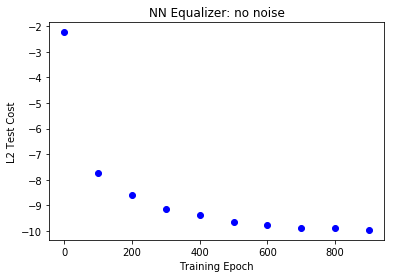

In [4]:
### CFO Multitap channel ###

import matplotlib.pyplot as plt   
import numpy as np

epochs = 1000
batch_size = 1500

print("Net trained on omega loss; without noise in preamble")



#     # generate the data
#     (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
# preamble_test_cfo, data_train_orig,data_train_cfo,data_test_orig,data_test_cfo) = data_generation(epochs)

mc_losses = []

# define equalizer NN class object
net2 = CFO_Multitap(preamble_length = 40, batch_size=1500, learning_rate = 0.005)

for epoch in range(epochs):
    current_start = epoch*batch_size
    omega_train_batch = omega_train[current_start:(current_start+batch_size),:]
    preamble_train_orig_batch = preamble_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_cfo_batch = preamble_train_cfo[current_start:(current_start+batch_size),:,:]   
    preamble_channel_batch = preamble_train_channel[current_start:(current_start+batch_size),:,:]

    train_cost = net2.train_net(preamble_train_orig_batch, preamble_train_cfo_batch, omega_train_batch,
                               preamble_channel_batch)

    if epoch % 100 == 0: 


        test_cost, test_omega, test_loss_mse = net2.test_net(preamble_test_orig,preamble_test_cfo,omega_test, 
                                              preamble_test_channel)

        mc_losses.append(test_cost)


        plt.plot(epoch, np.log(test_cost), 'bo')
        print('Epoch {}, Train Cost {}, Test Cost: {}, MSE Loss: {}'.format(epoch, train_cost,test_cost, 
                                                                            test_loss_mse))


plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()

# save the weights from the layers
with tf.variable_scope("cfo_layer_1", reuse=True):
    weights_1 = tf.get_variable("kernel")
with tf.variable_scope("cfo_layer_2", reuse=True):
    weights_2 = tf.get_variable("kernel")
with tf.variable_scope("cfo_layer_3", reuse=True):
    weights_3 = tf.get_variable("kernel")
with tf.variable_scope("cfo_layer_4", reuse=True):
    weights_4 = tf.get_variable("kernel")



True CFO Rate:  [0.00565321]
Estimate CFO Rate:  [-0.00527899]


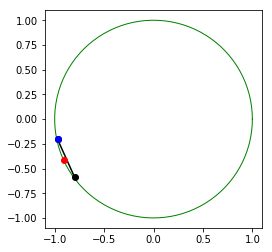

In [6]:

k=90
test_omega = np.array(test_omega)
print("True CFO Rate: ",omega_test[k])
print("Estimate CFO Rate: ",test_omega[k])

preamble_length=40


preamble_cfo_complex = np.vectorize(complex)(preamble_test_cfo[k,:,0], preamble_test_cfo[k,:,1])
preamble_cfo_complex=preamble_cfo_complex.reshape((preamble_length,1))
# print(preamble_cfo_complex.shape)

# build the rotation matrix
incremented_omega = np.zeros((preamble_length,1))
for i in range(preamble_length):
    incremented_omega[i]=-test_omega[k]*i

rotation_complex = np.exp(0.0+1j*incremented_omega)
# print(rotation_complex.shape)

# preamble_rotated_complex = np.multiply(preamble_cfo_complex,rotation_complex)
preamble_rotated_complex = (preamble_cfo_complex*rotation_complex)
# print(preamble_rotated_complex.shape)

preamble_rotated = np.stack([np.real(preamble_rotated_complex[:,:]), 
                             np.imag(preamble_rotated_complex[:,:])], axis=1)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1, color='g')
plt.gca().set_aspect('equal', adjustable='box')


m=39
for j in range(m,m+1):
    x1, x2 = preamble_test_channel[k,j,0], preamble_rotated[j,0]
    y1, y2 = preamble_test_channel[k,j,1], preamble_rotated[j,1]
    plt.plot([x1,x2],[y1,y2],'ko-')
    plt.plot(x1,y1,'bo')
    
    plt.plot(preamble_test_cfo[k,j,0], preamble_test_cfo[k,j,1],'ro')

    
# plt.plot(x1,y1,'bo')
plt.show()

Net trained on omega loss; with noise in preamble
Epoch 0, Train Cost 0.2684333622455597, Test Cost: 0.17193058133125305, MSE Loss: 1.0155162811279297
Epoch 100, Train Cost 0.0006156003219075501, Test Cost: 0.000574493664316833, MSE Loss: 0.228934183716774
Epoch 200, Train Cost 0.00022469859686680138, Test Cost: 0.00022300078126136214, MSE Loss: 0.15464410185813904
Epoch 300, Train Cost 0.00014489910972770303, Test Cost: 0.00013770730583928525, MSE Loss: 0.13481666147708893
Epoch 400, Train Cost 9.461453737458214e-05, Test Cost: 9.04045082279481e-05, MSE Loss: 0.12297359108924866
Epoch 500, Train Cost 7.698752597207204e-05, Test Cost: 7.368853403022513e-05, MSE Loss: 0.1189899891614914
Epoch 600, Train Cost 7.917926996015012e-05, Test Cost: 7.095842738635838e-05, MSE Loss: 0.11825651675462723
Epoch 700, Train Cost 6.19100610492751e-05, Test Cost: 5.6198477977886796e-05, MSE Loss: 0.11465398967266083
Epoch 800, Train Cost 5.766467802459374e-05, Test Cost: 6.240274524316192e-05, MSE Loss

Epoch 7400, Train Cost 1.6288649931084365e-05, Test Cost: 1.9451475964160636e-05, MSE Loss: 0.10397090762853622
Epoch 7500, Train Cost 1.8664370145415887e-05, Test Cost: 1.7031879906426184e-05, MSE Loss: 0.10348522663116455
Epoch 7600, Train Cost 1.6607413272140548e-05, Test Cost: 2.0749248506035656e-05, MSE Loss: 0.1041676476597786
Epoch 7700, Train Cost 1.528732173028402e-05, Test Cost: 1.6288277038256638e-05, MSE Loss: 0.10305095463991165
Epoch 7800, Train Cost 1.5747358702355996e-05, Test Cost: 1.8387127056485042e-05, MSE Loss: 0.10379892587661743
Epoch 7900, Train Cost 1.643632640480064e-05, Test Cost: 1.879801493487321e-05, MSE Loss: 0.1037057489156723
Epoch 8000, Train Cost 1.6805308405309916e-05, Test Cost: 1.5558525774395093e-05, MSE Loss: 0.10296354442834854
Epoch 8100, Train Cost 1.5920051737339236e-05, Test Cost: 1.5235489627229981e-05, MSE Loss: 0.10288308560848236
Epoch 8200, Train Cost 1.3984895304020029e-05, Test Cost: 1.4689948329760227e-05, MSE Loss: 0.102700017392635

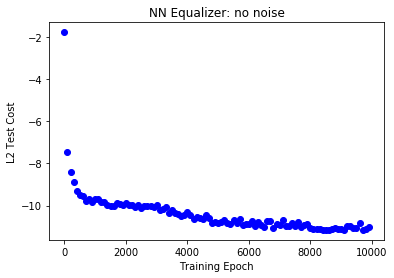

In [6]:
### CFO Multitap channel ###

import matplotlib.pyplot as plt   
import numpy as np

epochs = 10000
batch_size = 1500

print("Net trained on omega loss; with noise in preamble")



#     # generate the data
#     (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
# preamble_test_cfo, data_train_orig,data_train_cfo,data_test_orig,data_test_cfo) = data_generation(epochs)

mc_losses = []

# define equalizer NN class object
net2 = CFO_Multitap(preamble_length = 40, batch_size=1500, learning_rate = 0.005)

for epoch in range(epochs):
    current_start = epoch*batch_size
    omega_train_batch = omega_train[current_start:(current_start+batch_size),:]
    preamble_train_orig_batch = preamble_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_cfo_batch = preamble_train_noisy[current_start:(current_start+batch_size),:,:]   
    preamble_channel_batch = preamble_train_channel[current_start:(current_start+batch_size),:,:]

    train_cost = net2.train_net(preamble_train_orig_batch, preamble_train_cfo_batch, omega_train_batch,
                               preamble_channel_batch)

    if epoch % 100 == 0: 


        test_cost, test_omega, test_loss_mse = net2.test_net(preamble_test_orig,preamble_test_noisy,omega_test, 
                                              preamble_test_channel)

        mc_losses.append(test_cost)


        plt.plot(epoch, np.log(test_cost), 'bo')
        print('Epoch {}, Train Cost {}, Test Cost: {}, MSE Loss: {}'.format(epoch, train_cost,test_cost, 
                                                                            test_loss_mse))


plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()


True CFO Rate:  [-0.00963957]
Estimate CFO Rate:  [-0.00342418]


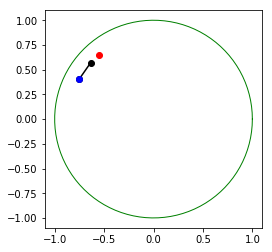

In [7]:
test_omega = np.array(test_omega)
print("True CFO Rate: ",omega_test[k])
print("Estimate CFO Rate: ",test_omega[k])

preamble_length=40


preamble_cfo_complex = np.vectorize(complex)(preamble_test_cfo[k,:,0], preamble_test_cfo[k,:,1])
preamble_cfo_complex=preamble_cfo_complex.reshape((preamble_length,1))
# print(preamble_cfo_complex.shape)

# build the rotation matrix
incremented_omega = np.zeros((preamble_length,1))
for i in range(preamble_length):
    incremented_omega[i]=-test_omega[k]*i

rotation_complex = np.exp(0.0+1j*incremented_omega)
# print(rotation_complex.shape)

# preamble_rotated_complex = np.multiply(preamble_cfo_complex,rotation_complex)
preamble_rotated_complex = (preamble_cfo_complex*rotation_complex)
# print(preamble_rotated_complex.shape)

preamble_rotated = np.stack([np.real(preamble_rotated_complex[:,:]), 
                             np.imag(preamble_rotated_complex[:,:])], axis=1)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1, color='g')
plt.gca().set_aspect('equal', adjustable='box')


m=39
for j in range(m,m+1):
    x1, x2 = preamble_test_channel[k,j,0], preamble_rotated[j,0]
    y1, y2 = preamble_test_channel[k,j,1], preamble_rotated[j,1]
    plt.plot([x1,x2],[y1,y2],'ko-')
    plt.plot(x1,y1,'bo')
    
    plt.plot(preamble_test_cfo[k,j,0], preamble_test_cfo[k,j,1],'ro')

    
# plt.plot(x1,y1,'bo')
plt.show()

In [10]:
import numpy as np
import tensorflow as tf

np.random.seed()
# tf.set_random_seed()

'''
CFO Multitap is a net that, given a known preamble, will take in the convolved preamble and estimate the CFO.
'''

class CFO_Multitap2():
    def __init__(self, preamble_length = 50, batch_size = 150, learning_rate = 0.01):           
        
        # Network variables
        self.preamble_length = preamble_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Placeholders for training
        self.preamble_original = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.preamble_convolved = tf.placeholder(tf.float32, [None, self.preamble_length, 2])
        self.preamble_channel = tf.placeholder(tf.float32, [None, self.preamble_length,2])
        self.omega_original = tf.placeholder(tf.float32, [None, 1])
            
        ###############
        # CFO Estimation using preambles
        ###############
        preamble_original_cfo = tf.concat([self.preamble_original, self.preamble_convolved], 1)

        preamble_original_cfo_flat = tf.contrib.layers.flatten(preamble_original_cfo)
        
        w1_init = tf.constant_initializer(weights_1)
        w2_init = tf.constant_initializer(weights_2)
        w3_init = tf.constant_initializer(weights_3)
        w4_init = tf.constant_initializer(weights_4)

        cfo_layer_1 = tf.layers.dense(
          preamble_original_cfo_flat, 100, tf.nn.tanh, use_bias=True, kernel_initializer= w1_init)
        cfo_layer_2 = tf.layers.dense(
          cfo_layer_1, 100, tf.nn.tanh, use_bias=True, kernel_initializer= w2_init)
        cfo_layer_3 = tf.layers.dense(
          cfo_layer_2, 100, activation=tf.nn.tanh, use_bias=True, kernel_initializer= w3_init)
        cfo_layer_4 = tf.layers.dense(
          cfo_layer_3, 1, activation=tf.identity, use_bias=True, kernel_initializer= w4_init)

        self.est_omega = cfo_layer_4
        
        
        ###############
        # CFO Correction on the convolved data
        ###############

        preamble_cfo_complex = tf.complex(self.preamble_convolved[:,:,0], self.preamble_convolved[:,:,1])
        preamble_cfo_complex = tf.expand_dims(preamble_cfo_complex, -1)

        # build the rotation matrix
        incremented_omega = []
        for i in range(preamble_length):
            incremented_omega.append(-self.est_omega*i)

        rotation_complex = tf.exp(tf.complex(0.0,tf.transpose(incremented_omega, perm=[1,0,2])))
        preamble_rotated_complex = tf.multiply(preamble_cfo_complex,rotation_complex)

        preamble_rotated = tf.stack([tf.real(preamble_rotated_complex[:,:]), 
                                     tf.imag(preamble_rotated_complex[:,:])], axis=2)
        
        self.preamble_cfo_corrected = tf.squeeze(preamble_rotated,-1)
#         self.preamble_cfo_corrected=[]
#         for j in range(self.batch_size):
            
#             preamble_corr = []
#             for k in range(self.preamble_length):
#                 real = (self.preamble_channel[j,k,0]*tf.cos(self.est_omega[j]*k)
#                                            -self.preamble_channel[j,k,1]*tf.sin(self.est_omega[j]*k))
#                 imag = (self.preamble_channel[j,k,0]*tf.sin(self.est_omega[j]*k)
#                                           +self.preamble_channel[j,k,1]*tf.cos(self.est_omega[j]*k))
#                 preamble_corr.append(tf.concat([real,imag], 0))
                
#             self.preamble_cfo_corrected.append(preamble_corr)
    
    
        ###############################################
        # Define surrogate loss and optimization tensor
        ###############################################
        self.surr = tf.losses.mean_squared_error(self.preamble_channel, self.preamble_cfo_corrected)
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update_op = self.optimizer.minimize(self.surr)

        ###############
        # Start session
        ###############
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
            

    def test_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Test net function. Evaluates the session
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            test_cost, error between the data_original and the estimated data
        """

        test_cost, test_omega, test_est = self.sess.run([self.surr,self.est_omega, self.preamble_cfo_corrected],
                                                        feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        return test_cost,test_omega
    
            
    def train_net(self, preamble_original, preamble_convolved, omega_original, preamble_channel):
        """
        Train net function. Calls self.update_op.
        Inputs:
            self.preamble_original, the original preamble that was sent prior to noise, CFO, and channel
            self.preamble_convolved, preamble after noise, CFO, and channel
            self.data_original, the original data that was sent prior to noise, CFO, and channel
            self.data_convolved, data after noise, CFO, and channel
            self.channel, channel that is applied to the I and Q of the preamble and data streams
        Outputs:
            train_cost, error between the data_original and the estimated data
        """

        _ , train_cost = self.sess.run([self.update_op, self.surr], feed_dict={
                self.preamble_original: preamble_original,
                self.preamble_convolved: preamble_convolved,
                self.omega_original: omega_original,
                self.preamble_channel: preamble_channel
        })
        
        return train_cost
    


In [11]:
### CFO Preamble Loss ###

import matplotlib.pyplot as plt   
import numpy as np

epochs = 1000
batch_size = 150

#     # generate the data
#     (channel_train, channel_test, preamble_train_orig, preamble_train_cfo, preamble_test_orig, 
# preamble_test_cfo, data_train_orig,data_train_cfo,data_test_orig,data_test_cfo) = data_generation(epochs)

mc_losses = []

# define equalizer NN class object
net3 = CFO_Multitap2(preamble_length = 40, batch_size=150, learning_rate = 0.01)

for epoch in range(epochs):
    current_start = epoch*batch_size
    omega_train_batch = omega_train[current_start:(current_start+batch_size),:]
    preamble_train_orig_batch = preamble_train_orig[current_start:(current_start+batch_size),:,:]
    preamble_train_cfo_batch = preamble_train_cfo[current_start:(current_start+batch_size),:,:]
    preamble_train_channel_batch = preamble_train_channel[current_start:(current_start+batch_size),:,:]

    train_cost = net3.train_net(preamble_train_orig_batch, preamble_train_cfo_batch, omega_train_batch,
                               preamble_train_channel_batch)

    if epoch % 100 == 0: 
        omega_test_batch = omega_test[current_start:(current_start+batch_size),:]
        preamble_test_orig_batch = preamble_test_orig[current_start:(current_start+batch_size),:,:]
        preamble_test_cfo_batch = preamble_test_cfo[current_start:(current_start+batch_size),:,:]
        preamble_test_channel_batch = preamble_test_channel[current_start:(current_start+batch_size),:,:]

        test_cost, test_omega = net3.test_net(preamble_test_orig_batch,preamble_test_cfo_batch,omega_test_batch,
                                              preamble_test_channel_batch)

        mc_losses.append(test_cost)


        plt.plot(epoch, np.log(test_cost), 'bo')
        print('Epoch {}, Train Cost {}, Test Cost: {}'.format(epoch, train_cost,test_cost))


plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()


TypeError: Invalid type for initial value: <class 'tensorflow.python.ops.variables.Variable'> (expected Python scalar, list or tuple of values, or numpy.ndarray).